# Predicting Match Outcomes

In [1]:
#SQL Imports
import mysql.connector
#Pandas imports
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt


In [2]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="NYg1@nts",
  database="NRL_data"
)
mycursor = mydb.cursor()

## Create match_stat_df

First I will compile a dataframe of match stats for each team by aggregating individual player stats for each team. 

In [3]:
query = pd.read_sql_query('''
    SELECT * 
    FROM PlayerMatchStats
''', mydb)
player_stat_df = pd.DataFrame(query)
match_stat_df = player_stat_df.groupby(['match_id','team_id']).sum().reset_index()
match_stat_df = match_stat_df.drop(columns=['id', 'player_id', 'position_id', 'minutes_played'])
#match_stat_df.columns
#print(match_stat_df.dtypes)

In [4]:
def get_averages(df):
    df['metres_per_kick'] = df['kicking_metres'] / df['kicks']
    df['metres_per_run'] = df['total_run_metres'] / df['total_runs']
    df['metres_ran_per_try'] = df['total_run_metres'] / df['tries']
    df['tackle_percentage'] = df['tackles_made'] / (df['tackles_made'] + df['tackles_missed'] + df['ineffective_tackles'])
    return df
match_stat_df = get_averages(match_stat_df)
match_stat_df = match_stat_df.drop(columns=['average_play_ball_seconds']).fillna(0)
match_stat_df.head()

,match_id,team_id,points,tries,conversions,conversion_attempts,penalty_goals,field_goals,total_runs,total_run_metres,...,handling_errors,one_on_ones_lost,penalties,on_report,sin_bins,send_offs,metres_per_kick,metres_per_run,metres_ran_per_try,tackle_percentage
0,1,1,12,2,1,2,1,0,130,1076,...,11,0,9,1,0,0,27.285714,8.276923,538.000000,0.871465
1,1,14,34,5,4,5,3,0,168,1618,...,9,2,7,0,0,0,28.117647,9.630952,323.600000,0.888060
2,2,6,18,3,2,3,1,0,178,1648,...,10,0,11,0,0,0,21.846154,9.258427,549.333333,0.888350
3,2,8,19,3,3,3,0,1,192,1425,...,6,0,9,0,0,0,25.619048,7.421875,475.000000,0.846535
4,3,4,14,2,2,2,1,0,134,1144,...,12,0,10,0,0,0,20.928571,8.537313,572.000000,0.865952


Next, I will combine the aggregated player stats with the date and id of the winning team for each match.

In [5]:
match_query = pd.read_sql_query('''
    SELECT id, date, round, home_team_id, home_score, away_team_id, away_score, winner, home_odds, away_odds, draw_odds
    FROM Matches
''', mydb)
match_df = pd.DataFrame(match_query).rename(columns={'id': 'match_id'})
match_df['date'] = pd.to_datetime(match_df['date'])

#Add date to match_stat_df
match_stat_df = pd.merge(match_stat_df, match_df[['match_id', 'date', 'winner']], on='match_id', how='inner')
match_stat_df['is_winner'] = match_stat_df.apply(lambda x: 1 if x['team_id'] == x['winner'] else 0, axis=1)
match_stat_df = match_stat_df.drop(columns='winner')
match_stat_df.head()

,match_id,team_id,points,tries,conversions,conversion_attempts,penalty_goals,field_goals,total_runs,total_run_metres,...,penalties,on_report,sin_bins,send_offs,metres_per_kick,metres_per_run,metres_ran_per_try,tackle_percentage,date,is_winner
0,1,1,12,2,1,2,1,0,130,1076,...,9,1,0,0,27.285714,8.276923,538.000000,0.871465,2018-03-08,0
1,1,14,34,5,4,5,3,0,168,1618,...,7,0,0,0,28.117647,9.630952,323.600000,0.888060,2018-03-08,1
2,2,6,18,3,2,3,1,0,178,1648,...,11,0,0,0,21.846154,9.258427,549.333333,0.888350,2018-03-09,0
3,2,8,19,3,3,3,0,1,192,1425,...,9,0,0,0,25.619048,7.421875,475.000000,0.846535,2018-03-09,1
4,3,4,14,2,2,2,1,0,134,1144,...,10,0,0,0,20.928571,8.537313,572.000000,0.865952,2018-03-09,0


# Create class for teams and matches

In [6]:
class Teams:
    all_teams = {}
    
    def __init__(self, name, id):
        self.name = name
        self.id = id
        self.match_stats = match_stat_df[match_stat_df['team_id'] == self.id]
        self.opposition_stats = self.get_opposition_stats()
        Teams.all_teams[self.name] = self
    
    #This function is currently in progress
    def get_roster(self):
        roster_df = player_stat_df[player_stat_df['team_id'] == self.id]
        roster_df = pd.merge(roster_df, match_df[['match_id', 'date']], on='match_id', how='inner')
        for match in list(roster_df['match_id'].unique()):
            #print(roster_df.head())
            df = roster_df[roster_df['match_id'] == match]
            df = list(df['player_id'])
            #print(df)
    
    def get_opposition_stats(self):
        match_ids = list(self.match_stats['match_id'])
        opposition_df = match_stat_df[(match_stat_df['match_id'].isin(match_ids)) & (match_stat_df['team_id'] != self.id)]
        return opposition_df
    
    def get_stats_most_recent_matches(self, date, x=1):
        date_df = self.match_stats[self.match_stats['date'] < date].sort_values('date', ascending=False)
        date_df = date_df.drop(columns=['date'])
        averages_df = date_df.head(x).sum() / x
        return averages_df
    
    def get_opposition_stats_most_recent_matches(self, date, x=1):
        date_df = self.opposition_stats[self.opposition_stats['date'] < date].sort_values('date', ascending=False)
        date_df = date_df.drop(columns=['date'])
        averages_df = date_df.head(x).sum() / x
        return averages_df
    
    def get_season_averages(self, year, self_or_opposition = 'self'):
        if self_or_opposition == 'opposition':
            stats = self.opposition_stats
        else:
            stats = self.match_stats
        date_df = stats[stats['date'].dt.year == year]
        date_df.drop(columns=['date'])
        averages_df = date_df.sum() / date_df.shape[0]
        return averages_df

    
#Create a class object for each team
team_names_and_ids = pd.DataFrame(pd.read_sql_query('SELECT id, nickname FROM Teams', mydb)).set_index('nickname').to_dict()['id']
for name in team_names_and_ids.keys():
     Teams(name, team_names_and_ids[name])
#print(Teams.all_teams['Roosters'].opposition_stats.head())
#print(Teams.all_teams['Roosters'].get_season_averages(2014))

In [7]:
#Teams.all_teams['Roosters'].get_roster()

In [8]:
class Matches:
    all_matches = {}
    
    def __init__(self, match_id, round, date, home_team, away_team, winner=None, home_odds=None, away_odds=None):
        self.id = match_id
        self.round = round
        self.date = date
        self.season = self.date.year
        self.home = home_team
        self.home_odds = home_odds
        self.away = away_team
        self.away_odds = away_odds
        if home_team.id == winner:
            self.winner = home_team
            self.home_winner = True
        else:
            self.winner = away_team
            self.home_winner = False
        self.stats = self.get_match_stats()
        self.identifier = str(self.date.date()) + '_' + str(self.id) + '_' + self.home.name + '-v-' + self.away.name
        Matches.all_matches[self.identifier] = self
        #Matches.all_matches.append(self)
    
    def get_match_stats(self):
        match_stats = pd.DataFrame()
        home_stats = self.home.match_stats[self.home.match_stats['match_id'] == self.id]
        away_stats = self.away.match_stats[self.away.match_stats['match_id'] == self.id]
        for column in list(home_stats.columns)[2:-2]:
            match_stats['h_' + column] = [home_stats[column].values[0]]
            match_stats['a_' + column] = [away_stats[column].values[0]]
            #match_stats['diff_' + column] = match_stats['h_' + column] - match_stats['a_' + column]
        return match_stats
    
    def predict_winner():
        pass

In [9]:
def create_match_objects(match):
    for key, value in Teams.all_teams.items():
        if match['home_team_id'] == Teams.all_teams[key].id:
            home_team = Teams.all_teams[key]
        if match['away_team_id'] == Teams.all_teams[key].id:
            away_team = Teams.all_teams[key]
    Matches(match['match_id'], match['round'], match['date'], home_team, away_team, match['winner'], match['home_odds'], match['away_odds'])
    
match_df.apply(lambda x: create_match_objects(x), axis = 1)

#Verification that code worked
#Matches.all_matches['2018-03-09_3_Cowboys-v-Sharks'].stats


0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
1377    None
1378    None
1379    None
1380    None
1381    None
1382    None
1383    None
1384    None
1385    None
1386    None
1387    None
1388    None
1389    None
1390    None
1391    None
1392    None
1393    None
1394    None
1395    None
1396    None
1397    None
1398    None
1399    None
1400    None
1401    None
1402    None
1403    None
1404    None
1405    None
1406    None
Length: 1407, dtype: object

## Feature Selection

In [10]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

features = pd.DataFrame()
for key in Matches.all_matches:
    match = Matches.all_matches[key]
    match_row = match.stats
    match_row['id'] = match.id
    match_row['h_win'] = match.home_winner
    features = features.append(match_row)
features = features.set_index('id')
features['h_win'] = features['h_win'].replace({True: 1, False: 0})
features.head()

,h_points,a_points,h_tries,a_tries,h_conversions,a_conversions,h_conversion_attempts,a_conversion_attempts,h_penalty_goals,a_penalty_goals,...,a_send_offs,h_metres_per_kick,a_metres_per_kick,h_metres_per_run,a_metres_per_run,h_metres_ran_per_try,a_metres_ran_per_try,h_tackle_percentage,a_tackle_percentage,h_win
id,,,,,,,,,,,,,,,,,,,,,
1,34,12,5,2,4,1,5,2,3,1,...,0,28.117647,27.285714,9.630952,8.276923,323.60,538.000000,0.888060,0.871465,1
2,19,18,3,3,3,2,3,3,0,1,...,0,25.619048,21.846154,7.421875,9.258427,475.00,549.333333,0.846535,0.888350,1
3,20,14,4,2,1,2,4,2,1,1,...,0,19.384615,20.928571,8.169697,8.537313,337.00,572.000000,0.877419,0.865952,1
4,10,8,1,1,1,1,1,1,1,1,...,0,24.521739,28.684211,8.839779,8.296512,1600.00,1427.000000,0.898667,0.860406,0
5,20,32,4,6,2,3,4,6,0,1,...,0,25.777778,25.437500,9.754717,9.754601,387.75,265.000000,0.864000,0.855385,0


In [11]:
##Troubleshoot issue with infinity values...occurred in metres_ran_per_try when no tries were scored
features = features.replace([np.inf, -np.inf], 0)
filter = [col for col in features if (col.startswith('h_') | col.startswith('a_'))]
features = features[filter]

In [12]:
X = features.iloc[:, :-1]
Y = features['h_win']

#Create a SelectKBest object to select features with the best ANOVOA F-Values
fvalue_selector = SelectKBest(score_func=f_classif, k=15)
fvalue_selector.fit_transform(X, Y)

f_scores_df = pd.DataFrame(dict(feature_names = X.columns, f_scores = fvalue_selector.scores_)).sort_values('f_scores', ascending=False)
f_scores_df[f_scores_df['f_scores'] > 60]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [26 27] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,feature_names,f_scores
0,h_points,685.664954
1,a_points,676.611124
2,h_tries,564.665038
6,h_conversion_attempts,557.746359
3,a_tries,535.805577
7,a_conversion_attempts,527.801310
5,a_conversions,478.179379
4,h_conversions,429.497824
24,h_try_assists,380.860270
25,a_try_assists,341.249165


In [15]:

#columns = h_points, a_points, h_line_breaks, a_line_breaks, h_total_run_metres, a_total_run_metres
#h_tackles_made, a_tackles_made, 
#columns_to_add = ['h_win_percentage', 'a_win_percentage']


## Generate df of historical data for making predictions

In [19]:
predictions_data = {}
pd.DataFrame()

for i in range(1, 11):
    print(i)
    predictions_data[str(i)] = pd.DataFrame()
    for key in Matches.all_matches:
        prediction_row = {} 
        match = Matches.all_matches[key]
        prediction_row['match_id'] = match.id
        prediction_row['date'] = match.date
        year = match.season
        prediction_row['round'] = match.round
        h = match.home
        a = match.away
        if match.home_winner is True:
            prediction_row['home_winner'] = 1
        else:
            prediction_row['home_winner'] = 0
    
        team_stats = ['points', 'line_breaks', 'total_run_metres', 'tackles_made', 'is_winner']
        opposition_stats = ['points', 'line_breaks', 'total_run_metres', 'tackles_made']
    
        renaming_dict = {
            'points': 'points_allowed',
            'line_breaks': 'line_breaks_allowed',
            'total_run_metres': 'total_run_metres_allowed',
            'tackles_made': 'tackles_by_opposition'
        }
    
        if (np.isnan(match.round)) | int(match.round > i):
            home_stats = h.get_stats_most_recent_matches(match.date, i)[team_stats]
            home_opposition_stats = h.get_opposition_stats_most_recent_matches(match.date, i)[opposition_stats]
        
            away_stats = a.get_stats_most_recent_matches(match.date, i)[team_stats]
            away_opposition_stats = a.get_opposition_stats_most_recent_matches(match.date, i)[opposition_stats]
    
        elif int(match.round) == 1:
            home_stats = h.get_season_averages(year - 1)[team_stats]
            home_opposition_stats = h.get_season_averages(year - 1)[opposition_stats]
        
            away_stats = a.get_season_averages(year - 1)[team_stats]
            away_opposition_stats = a.get_season_averages(year - 1)[opposition_stats]
    
        else:
            home_stats = h.get_stats_most_recent_matches(match.date, int(match.round) - 1)[team_stats]
            home_stats = ((home_stats / i) * (i - int(match.round))) + ((h.get_season_averages(year - 1)[team_stats] / i) * int(match.round))
            
            away_stats = a.get_stats_most_recent_matches(match.date, int(match.round) - 1)[team_stats]
            away_stats = ((away_stats / i) * (i - int(match.round))) + ((a.get_season_averages(year - 1)[team_stats] / i) * int(match.round))
        
            home_opposition_stats = h.get_opposition_stats_most_recent_matches(match.date, int(match.round) - 1)[opposition_stats]
            home_opposition_stats = ((home_opposition_stats / i) * (i - int(match.round))) + ((h.get_season_averages(year - 1)[opposition_stats] / i) * int(match.round))
            
            away_opposition_stats = a.get_opposition_stats_most_recent_matches(match.date, int(match.round) - 1)[opposition_stats]
            away_opposition_stats = ((away_opposition_stats / i) * (i - int(match.round))) + ((a.get_season_averages(year - 1)[opposition_stats] / i) * int(match.round))
        
        
#             home_stats['is_winner'] = ((h.get_season_averages(year - 1)['is_winner'] / i) * int(match.round))\
#                 + ((home_stats['is_winner'] / i) * (i - int(match.round)))
#             away_stats['is_winner'] = ((a.get_season_averages(year - 1)['is_winner'] / i) * int(match.round))\
#                 + ((away_stats['is_winner'] / i) * (i - int(match.round)))

        home_opposition_stats = home_opposition_stats.rename(renaming_dict)
        away_opposition_stats = away_opposition_stats.rename(renaming_dict)
        for stat in team_stats:
            prediction_row['h_' + stat] = home_stats[stat]
            prediction_row['a_' + stat] = away_stats[stat]
        for key, value in home_opposition_stats.items():
            prediction_row['h_' + key] = home_opposition_stats[key]
            prediction_row['a_' + key] = away_opposition_stats[key]
    
        predictions_data[str(i)] = predictions_data[str(i)].append(prediction_row, ignore_index=True)
    predictions_data[str(i)]['match_id'] = predictions_data[str(i)]['match_id'].astype(int)
    predictions_data[str(i)] = predictions_data[str(i)].sort_values(by='date')


1
2
3
4
5
6
7
8
9
10


In [20]:
for key in predictions_data:
    predictions_data[key]['round'] = predictions_data[key]['round'].fillna(0)
    predictions_data[key] = predictions_data[key].dropna(axis=0)
    predictions_data[key] = predictions_data[key].replace([np.inf, -np.inf], 0)
#predictions_data['5']

## Model Selection

Three models I will test out are Logistic Regression, Random Forest and a Gradient Boosting Tree.

## Logistic Rregression

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set()

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [61]:
for key in predictions_data:
    data = predictions_data[key]
    #data = data.replace([np.inf, -np.inf], 0)
    
    train = data[data['date'].dt.year < 2019]
    test = data[data['date'].dt.year == 2019]
    
    X_train = StandardScaler().fit_transform(train.drop(columns=['home_winner', 'match_id', 'round', 'date']))
    y_train = train['home_winner']
    
    lr = LogisticRegression()
    scores = cross_val_score(lr, X_train, y_train, cv = 10)
    print('Prior ' + key + ' matches: ' + str(np.round(scores.mean(), 4)))
    
    lr = LogisticRegression()
    X_test = StandardScaler().fit_transform(test.drop(columns=['home_winner', 'match_id', 'round', 'date']))
    y_test = test['home_winner']
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    
    
    
    #X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.2, random_state=42)
    #log_reg = LogisticRegression()
    #log_reg.fit(X_train, y_train)
    #y_pred = log_reg.predict(X_test)
    
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    #roc_auc = auc(false_positive_rate, true_positive_rate)
    #print('Prior ' + key + ' matches: ' + str(np.round((accuracy_score(y_test, y_pred)), 4)) + ' - AUC: ' + str(np.round(roc_auc, 4)))

Prior 1 matches: 0.5609
0.527363184079602
Prior 2 matches: 0.5806
0.5522388059701493
Prior 3 matches: 0.5795
0.5522388059701493
Prior 4 matches: 0.5766
0.5422885572139303
Prior 5 matches: 0.5755
0.5472636815920398
Prior 6 matches: 0.5717
0.5671641791044776
Prior 7 matches: 0.5983
0.5373134328358209
Prior 8 matches: 0.5876
0.5422885572139303
Prior 9 matches: 0.5847
0.5422885572139303
Prior 10 matches: 0.5844
0.5572139303482587


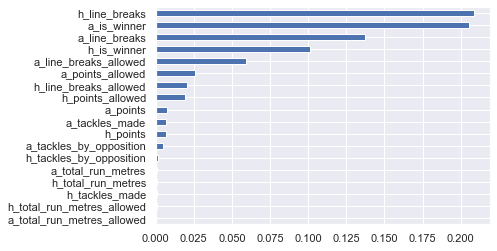

In [26]:
data = predictions_data['7']
train = data[data['date'].dt.year < 2019]
test = data[data['date'].dt.year == 2019]

#data = data.replace([np.inf, -np.inf], 0)
X_train = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
#X_scaled = StandardScaler().fit_transform(X)
y_train = data['home_winner']
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

coefficients = log_reg.coef_
feature_importance = pd.Series(coefficients[0], index=X_train.columns)
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

In [62]:
data = predictions_data['7']
train = data[data['date'].dt.year < 2019]
test = data[data['date'].dt.year == 2019]
X_train = train.drop(columns=['home_winner', 'match_id', 'round', 'date'])
y_train = train['home_winner']
#data = data.replace([np.inf, -np.inf], 0)
feature_index = 0
for feature in list(ordered_feature_importance.sort_values(ascending=False).index):
    feature_index += 1
    features = list(ordered_feature_importance.sort_values(ascending=False).index)[:feature_index]
    X = StandardScaler().fit_transform(X_train[features])
    y = train['home_winner']
    
    lr = LogisticRegression()
    lr.fit(X, y)
    scores = cross_val_score(lr, X, y, cv = 10)
    #print(feature_index)
    print('Top ' + str(feature_index) + ' features: ' + str(np.round(scores.mean(), 4)))
    
    lr = LogisticRegression()
    test_refined = test.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X_test = StandardScaler().fit_transform(test_refined[features])
    y_test = test['home_winner']
    lr.fit(X, y)
    y_pred = lr.predict(X_test)
    print(accuracy_score(y_test, y_pred))

Top 1 features: 0.5748
0.5373134328358209
Top 2 features: 0.5791
0.5472636815920398
Top 3 features: 0.5783
0.5522388059701493
Top 4 features: 0.5835
0.5522388059701493
Top 5 features: 0.5765
0.5572139303482587
Top 6 features: 0.5852
0.5621890547263682
Top 7 features: 0.5853
0.5572139303482587
Top 8 features: 0.5904
0.5572139303482587
Top 9 features: 0.5861
0.5572139303482587
Top 10 features: 0.5948
0.572139303482587
Top 11 features: 0.5948
0.572139303482587
Top 12 features: 0.5887
0.5671641791044776
Top 13 features: 0.5922
0.5671641791044776
Top 14 features: 0.6105
0.5323383084577115
Top 15 features: 0.607
0.5323383084577115
Top 16 features: 0.6027
0.5422885572139303
Top 17 features: 0.5966
0.5373134328358209
Top 18 features: 0.5983
0.5373134328358209


In [57]:
top_features = list(ordered_feature_importance.sort_values(ascending=False).index)[:10]

In [58]:
data = predictions_data['7']
    #data = data.replace([np.inf, -np.inf], 0)
    
train = data[data['date'].dt.year < 2019]
test = data[data['date'].dt.year == 2019]
    
X_train = StandardScaler().fit_transform(train[top_features])
y_train = train['home_winner']
X_test = StandardScaler().fit_transform(test[top_features])
y_test = test['home_winner']
    
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.5572139303482587


## Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = list(range(1, 300, 20))
random_forest_results = pd.DataFrame({'estimators': n_estimators})
random_state = 0
#for key in predictionos_data:
for key in ['7']:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf], 0)

    
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X = X[list(ordered_feature_importance.sort_values(ascending=False).index)[:4]]
    y = data['home_winner']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    #key_results = []
    accuracy_scores = []
    auc_scores = []
    for i in n_estimators:
        #random_state += 1
        forest = RandomForestClassifier(n_estimators = i, random_state=42)
        forest.fit(X_train, y_train)
        forest_pred = forest.predict(X_test)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, forest_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        auc_scores.append(roc_auc)
        
        score = np.round(accuracy_score(y_test, forest_pred), 4)
        accuracy_scores.append(score)
        #print('Previous ' + key + ' matches - ' + str(i) + ' estimators accuracy: ' + str(np.round(score, 4)))
    #random_forest_results[key] = key_results

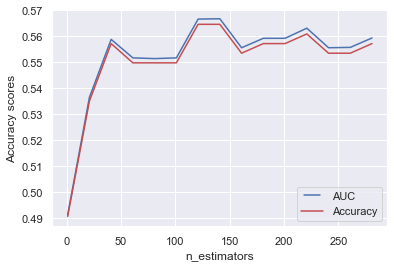

In [70]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, auc_scores, 'b', label="AUC")
line2, = plt.plot(n_estimators, accuracy_scores, 'r', label="Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy scores')
plt.xlabel('n_estimators')
plt.show()

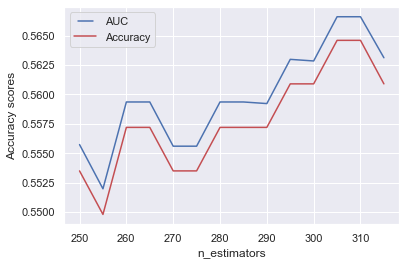

In [71]:
n_estimators = list(range(250, 320, 5))
random_forest_results = pd.DataFrame({'estimators': n_estimators})
random_state = 0
#for key in predictionos_data:
for key in ['7']:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf], 0)

    
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X = X[list(ordered_feature_importance.sort_values(ascending=False).index)[:4]]
    y = data['home_winner']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    #key_results = []
    accuracy_scores = []
    auc_scores = []
    for i in n_estimators:
        #random_state += 1
        forest = RandomForestClassifier(n_estimators = i, random_state=42)
        forest.fit(X_train, y_train)
        forest_pred = forest.predict(X_test)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, forest_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        auc_scores.append(roc_auc)
        
        score = np.round(accuracy_score(y_test, forest_pred), 4)
        accuracy_scores.append(score)
        #print('Previous ' + key + ' matches - ' + str(i) + ' estimators accuracy: ' + str(np.round(score, 4)))
    #random_forest_results[key] = key_results
line1, = plt.plot(n_estimators, auc_scores, 'b', label="AUC")
line2, = plt.plot(n_estimators, accuracy_scores, 'r', label="Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy scores')
plt.xlabel('n_estimators')
plt.show()

In [72]:
max_depths = np.linspace(1, 30, 32, endpoint=True)
random_forest_results = pd.DataFrame({'estimators': max_depths})
random_state = 0
#for key in predictionos_data:
for key in ['7']:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf], 0)

    
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    y = data['home_winner']
    #key_results = []
    train_results = []
    test_results = []
    for i in max_depths:
        #random_state += 1
        forest = RandomForestClassifier(max_depth = i, random_state=42)
        forest.fit(X_train, y_train)
        train_pred = forest.predict(X_train)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        y_pred = forest.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)

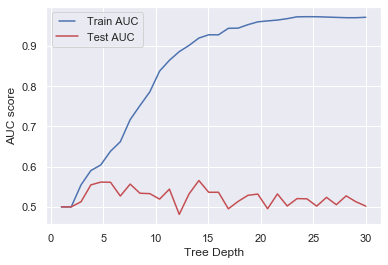

In [73]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree Depth')
plt.show()

[0.5277]
[0.5277, 0.5461]
[0.5277, 0.5461, 0.5572]
[0.5277, 0.5461, 0.5572, 0.5166]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277, 0.5277]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277, 0.5277, 0.5351]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277, 0.5277, 0.5351, 0.5572]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277, 0.5277, 0.5351, 0.5572, 0.5683]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277, 0.5277, 0.5351, 0.5572, 0.5683, 0.5387]


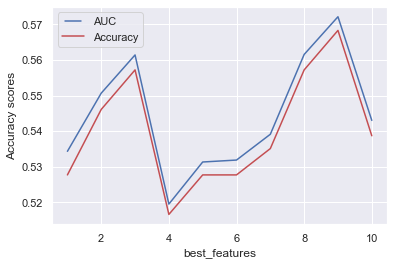

In [76]:
## max_depth = 4
## n_estimators = 305

data = predictions_data['7']
data = data.replace([np.inf, -np.inf], 0)

accuracy_scores = []
auc_scores = []
best_features = list(range(1, 11))
for i in best_features:
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X = X[list(ordered_feature_importance.sort_values(ascending=False).index)[:i]]
    y = data['home_winner']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    
    forest = RandomForestClassifier(n_estimators = 305, max_depth = 4, random_state=42)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_test)
        
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, forest_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    auc_scores.append(roc_auc)
        
    score = np.round(accuracy_score(y_test, forest_pred), 4)
    accuracy_scores.append(score)
    print(accuracy_scores)
    
line1, = plt.plot(best_features, auc_scores, 'b', label="AUC")
line2, = plt.plot(best_features, accuracy_scores, 'r', label="Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy scores')
plt.xlabel('best_features')
plt.show()

## Gradient Boosting Tree

In [77]:
from sklearn.ensemble import GradientBoostingClassifier
n_estimators = list(range(1, 300, 20))
gradient_results = pd.DataFrame({'estimators': n_estimators})
for key in ['7']:
#for key in predictions_data:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf, np.nan], 0)
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    y = data['home_winner']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    key_results = []
    for i in n_estimators:
        gradient = GradientBoostingClassifier(n_estimators = i, random_state=42)
        gradient.fit(X_train, y_train)
        gradient_pred = gradient.predict(X_test)
        score = np.round(accuracy_score(y_test, gradient_pred), 4)
        key_results.append(score)
        print('Previous ' + key + ' matches - ' + str(i) + ' estimators accuracy: ' + str(np.round(score, 4)))
    #gradient_results[key] = key_results
#gradient_results = gradient_results.set_index('estimators')
#gradient_results

Previous 7 matches - 1 estimators accuracy: 0.5498
Previous 7 matches - 21 estimators accuracy: 0.5314
Previous 7 matches - 41 estimators accuracy: 0.572
Previous 7 matches - 61 estimators accuracy: 0.583
Previous 7 matches - 81 estimators accuracy: 0.5756
Previous 7 matches - 101 estimators accuracy: 0.5535
Previous 7 matches - 121 estimators accuracy: 0.5609
Previous 7 matches - 141 estimators accuracy: 0.5461
Previous 7 matches - 161 estimators accuracy: 0.5351
Previous 7 matches - 181 estimators accuracy: 0.5277
Previous 7 matches - 201 estimators accuracy: 0.5277
Previous 7 matches - 221 estimators accuracy: 0.5351
Previous 7 matches - 241 estimators accuracy: 0.5387
Previous 7 matches - 261 estimators accuracy: 0.5387
Previous 7 matches - 281 estimators accuracy: 0.5277


## Conclusion

From the accuracy scores obtained above, it looks like Logistic Regression is the best model to use for predicting match outcomes. Random Forest looks to be a close second. I will play around with the features some more and test them using both models as both produced similar results.

## To Do

1. Add a feature which represents the number of lineup changes on a week to week basis and see if that has an impact on predictions. 
    - Former rugby player turned data scientist Ben Darwin describes in this [article](https://www.rugbypass.com/news/the-ex-wallabies-prop-with-keen-eye-for-fascinating-analytics-darwin-australia/) how making frequent changes to a team's lineup decreases their probabily of winning
2. Further feature selection
    - Look for collinearity between existing features
    - Play around with additional features that could benefit the prediction algorithm
3. Modify the formula used to calculate team stats at the beginning of the season when previous games played for that season is a small sample size
4. Compare predictions to pre-match betting odds and see if betting odds can further improve the algorithm

## Adding lineup changes as a feature + dropping other features

In [44]:
query = pd.read_sql_query('''
    SELECT * 
    FROM PlayerMatchStats
''', mydb)
player_stat_df = pd.DataFrame(query)
player_stat_df.head()

for match in Matches.all_matches:
    match_id = Matches.all_matches[match].id
    home_id = Matches.all_matches[match].home.id
    home_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == home_id)]
    home_roster = list(home_df['player_id'])
    
    away_id = Matches.all_matches[match].away.id
    away_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == away_id)]
    away_roster = list(away_df['player_id'])
#match_stat_df = player_stat_df.groupby(['match_id','team_id']).sum().reset_index()
#match_stat_df = match_stat_df.drop(columns=['id', 'player_id', 'position_id', 'minutes_played'])

,id,match_id,player_id,team_id,position_id,minutes_played,points,tries,conversions,conversion_attempts,...,kicked_dead,errors,handling_errors,one_on_ones_lost,penalties,on_report,sin_bins,send_offs,stint_one,stint_two
0,1,1,385,14,1,80.0,0,0,0,0,...,0,0,0,0,1,0,0,0,80.0,None
1,2,1,481,14,2,80.0,0,0,0,0,...,0,1,1,0,0,0,0,0,80.0,None
2,3,1,378,14,3,80.0,4,1,0,0,...,0,0,0,0,0,0,0,0,80.0,None
3,4,1,388,14,3,80.0,0,0,0,0,...,0,3,2,0,0,0,0,0,80.0,None
4,5,1,482,14,2,80.0,4,1,0,0,...,0,1,1,0,0,0,0,0,80.0,None


In [65]:
for match in Matches.all_matches:
    match_id = Matches.all_matches[match].id
    home_id = Matches.all_matches[match].home.id
    home_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == home_id)]
    home_roster = list(home_df['player_id'])
    
    away_id = Matches.all_matches[match].away.id
    away_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == away_id)]
    away_roster = list(away_df['player_id'])
    

[385, 481, 378, 388, 482, 379, 376, 396, 391, 404, 407, 406, 483, 402, 484, 1626, 397]
[209, 212, 200, 213, 211, 208, 210, 192, 201, 503, 196, 188, 197, 504, 505, 194, 190]
[244, 254, 252, 250, 517, 258, 519, 272, 265, 268, 264, 520, 266, 260, 276, 267, 261]
[521, 458, 461, 522, 523, 457, 464, 453, 524, 448, 441, 452, 443, 440, 439, 449, 525]
[346, 527, 351, 352, 528, 349, 345, 369, 361, 366, 364, 529, 367, 360, 363, 368, 530]
[490, 491, 492, 84, 82, 493, 80, 494, 68, 495, 67, 70, 64, 61, 62, 538, 66]
[319, 323, 326, 543, 316, 320, 324, 330, 544, 332, 329, 545, 546, 335, 342, 547, 336]
[117, 112, 115, 554, 118, 555, 113, 127, 556, 132, 131, 557, 126, 134, 133, 558, 1639]
[91, 97, 87, 471, 472, 94, 89, 103, 473, 474, 475, 476, 477, 478, 479, 104, 480]
[432, 431, 486, 433, 487, 435, 430, 414, 413, 421, 409, 488, 412, 489, 424, 423, 417]
[22, 20, 27, 497, 26, 19, 498, 11, 3, 500, 2, 10, 501, 499, 9, 502, 566]
[531, 238, 532, 533, 241, 236, 534, 535, 225, 220, 224, 234, 231, 536, 230, 537,

[432, 431, 486, 433, 487, 435, 430, 414, 413, 421, 409, 412, 423, 488, 424, 417, 416]
[84, 491, 492, 79, 83, 81, 493, 62, 68, 64, 67, 72, 61, 77, 538, 69, 63]
[209, 591, 200, 622, 212, 1638, 210, 195, 191, 190, 196, 197, 188, 192, 194, 505, 628]
[346, 348, 530, 351, 344, 349, 345, 369, 361, 363, 364, 529, 367, 360, 588, 368, 347]
[385, 383, 378, 388, 482, 379, 376, 396, 391, 404, 407, 406, 483, 397, 484, 1626, 402]
[280, 279, 285, 548, 281, 550, 286, 614, 304, 306, 299, 305, 300, 283, 296, 302, 293]
[432, 431, 486, 433, 487, 488, 430, 414, 413, 421, 409, 412, 423, 489, 424, 417, 627]
[472, 91, 576, 471, 96, 94, 89, 103, 473, 474, 582, 476, 477, 605, 479, 102, 475]
[543, 323, 326, 318, 316, 320, 324, 332, 338, 330, 342, 545, 329, 325, 546, 547, 335]
[258, 254, 248, 620, 252, 249, 519, 272, 265, 268, 264, 260, 266, 244, 267, 261, 276]
[531, 238, 239, 533, 241, 236, 534, 535, 225, 221, 224, 220, 590, 227, 230, 222, 532]
[346, 347, 530, 351, 527, 349, 345, 369, 361, 363, 364, 529, 367, 360

[208, 218, 219, 215, 212, 216, 205, 191, 193, 196, 200, 194, 192, 195, 198, 188, 217]
[94, 97, 88, 92, 91, 95, 89, 102, 473, 474, 108, 478, 477, 93, 475, 616, 107]
[319, 323, 318, 1647, 314, 321, 320, 330, 1644, 329, 342, 545, 580, 327, 332, 335, 322]
[208, 218, 219, 215, 212, 216, 210, 205, 191, 195, 194, 200, 192, 213, 206, 190, 203]
[344, 351, 1646, 347, 348, 349, 345, 368, 361, 373, 364, 360, 362, 365, 1656, 374, 370]
[19, 28, 1652, 1653, 22, 6, 11, 3, 14, 2, 500, 18, 7, 9, 4, 12, 26]
[178, 185, 187, 179, 175, 174, 164, 159, 169, 162, 168, 161, 158, 160, 165, 182, 180]
[433, 431, 486, 428, 437, 435, 430, 414, 413, 421, 418, 417, 423, 412, 408, 422, 419]
[458, 468, 466, 461, 459, 457, 464, 569, 451, 439, 454, 441, 448, 445, 456, 443, 449]
[385, 382, 378, 388, 386, 1630, 397, 391, 390, 395, 406, 402, 400, 405, 376, 404, 407]
[19, 20, 28, 26, 22, 6, 11, 3, 14, 2, 500, 18, 7, 9, 4, 12, 1654]
[319, 323, 318, 1647, 314, 320, 324, 330, 1644, 329, 342, 327, 545, 580, 321, 332, 335]
[531, 5

[568, 185, 187, 589, 179, 539, 1806, 541, 159, 169, 162, 168, 161, 165, 2131, 160, 1994]
[491, 79, 492, 2058, 82, 1757, 490, 62, 68, 1970, 67, 61, 538, 1969, 64, 70, 493]
[2108, 591, 1858, 2101, 211, 504, 2102, 190, 191, 2103, 200, 2126, 197, 2104, 199, 603, 193]
[22, 20, 27, 2054, 497, 19, 498, 2056, 3, 2055, 2, 10, 501, 502, 499, 500, 2364]
[151, 145, 143, 507, 508, 2092, 142, 1713, 153, 509, 515, 155, 512, 513, 570, 2140, 571]
[40, 45, 41, 43, 42, 560, 33, 564, 55, 2078, 56, 563, 54, 2079, 58, 50, 565]
[482, 481, 378, 388, 484, 379, 2067, 2068, 391, 404, 407, 2069, 483, 406, 1642, 578, 2361]
[1966, 326, 318, 543, 316, 2071, 324, 330, 544, 335, 545, 329, 546, 2073, 332, 2074, 2070]
[280, 2030, 285, 549, 284, 293, 550, 553, 297, 306, 298, 305, 300, 552, 302, 294, 614]
[40, 45, 41, 43, 42, 560, 33, 564, 55, 2078, 56, 563, 54, 2079, 58, 565, 50]
[346, 530, 528, 2059, 1901, 364, 349, 369, 361, 363, 365, 529, 367, 621, 588, 2061, 360]
[280, 2030, 285, 549, 284, 293, 550, 553, 297, 306, 29

[151, 506, 143, 507, 508, 2092, 142, 2140, 153, 510, 515, 155, 512, 513, 571, 1713, 509]
[568, 185, 187, 177, 179, 175, 1806, 164, 159, 1994, 162, 1808, 168, 169, 1813, 2393, 2381]
[211, 591, 1858, 2101, 212, 2391, 2102, 193, 191, 195, 196, 194, 197, 2126, 2394, 199, 2383]
[385, 481, 1990, 388, 482, 379, 484, 406, 391, 404, 407, 2069, 483, 1642, 578, 390, 2067]
[1920, 459, 461, 522, 523, 521, 464, 1886, 2065, 610, 2115, 569, 448, 439, 599, 2392, 2395]
[2089, 486, 488, 417, 487, 435, 1677, 414, 413, 489, 409, 1679, 412, 2090, 421, 2091, 431]
[568, 185, 187, 177, 179, 175, 1806, 164, 159, 1994, 162, 1808, 161, 168, 169, 541, 1813]
[151, 506, 143, 507, 508, 2092, 142, 2140, 153, 510, 515, 155, 512, 513, 571, 1713, 509]
[472, 97, 2051, 471, 2050, 2052, 89, 103, 473, 474, 582, 476, 477, 475, 1836, 2114, 479]
[498, 20, 27, 2054, 497, 19, 2117, 499, 1704, 2055, 2, 10, 501, 2364, 2057, 9, 2056]
[287, 2030, 285, 293, 549, 550, 286, 294, 551, 306, 298, 575, 300, 552, 553, 297, 302]
[568, 185, 18

KeyboardInterrupt: 

In [137]:
results_df.head()
prediction_percent = len(results_df[results_df['correct_prediction'] == True]) / results_df.shape[0]
betting_percent = len(results_df[results_df['correct_odds'] == True]) / results_df.shape[0]                                   
print('prediction_percentage = ' + str(prediction_percent))
print('betting_percentage = ' + str(betting_percent))

prediction_percentage = 0.58
betting_percentage = 0.62


In [78]:
mycursor.close()

True